[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iabh1shekbasu/LungCancerDetectionEnsemble/blob/main/Probability_Extraction_and_Analysis.ipynb

)


## Connecting Google Drive

In [1]:
!pip cache purge
# !!pip install numpy==1.22.4 pandas==1.5.3 scipy==1.8.1
# !pip cache purge|
# !pip install scipy==1.7.3
# !pip install --force-reinstall --no-deps scipy==1.14.1

Files removed: 0


In [2]:
!pip install --force-reinstall --no-cache-dir scipy==1.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 260.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 298.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 196.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not inst

In [3]:
!pip install torchsummary

In [4]:
!pip uninstall scikit-plot -y
!pip install scikit-plot

Found existing installation: scikit-plot 0.3.7
Uninstalling scikit-plot-0.3.7:
  Successfully uninstalled scikit-plot-0.3.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 81.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.0
    Uninstalling numpy-2.2.0:
      Successfully uninstalled numpy-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.10.1 requires cubinlinker, which is not installed.
cudf 24.10.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.10.1 requires libcudf==24.10.*, which is not installed.
cudf 24.10.1 requires ptxcompiler, which is not installed.
cuml 24.10.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 24.10.0 requires cuvs==24.10.*, which is not installed.
cuml

In [5]:
# !google-drive-ocamlfuse

!ls '/kaggle/input/ensemble-learning-on-lidc-dataset/data'

densenet169.h5	       resnet152_test.csv  train
densenet169_test.csv   test		   train_labels.csv
densenet169_train.csv  test_labels.csv	   val


## Importing Libraries



This section imports necessary libraries required for the entire notebook. It includes deep learning libraries such as PyTorch, data manipulation libraries like NumPy, and visualization libraries such as matplotlib.

In [6]:
import time

import os

import copy

import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score

import torch

import torch.nn as nn

import torch.optim as optim

from torch.optim import lr_scheduler

import torchvision

from torchvision import datasets, models, transforms

from torch.utils.data import WeightedRandomSampler

## Data Preprocessing



This section defines the transformations to be applied to the input data for training and evaluation purposes. It includes normalization, resizing, and augmentation strategies.

In [7]:
mean = np.array([0.485, 0.456, 0.406])
# mean = np.array([0.5, 0.5, 0.5])


std = np.array([0.229, 0.224, 0.225])
# std = np.array([0.5, 0.5, 0.5])

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize all images to a uniform size
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.RandomVerticalFlip(p=0.3),  # Random vertical flip with 30% probability
        transforms.RandomRotation(degrees=20),  # Random rotation up to ±20 degrees
        transforms.ColorJitter(
            brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2
        ),  # Stronger color jittering
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Random crop and resize
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),  # Random blurring
        transforms.RandomGrayscale(p=0.1),  # Convert to grayscale with 10% probability
        transforms.ToTensor(),  # Convert PIL Image to Tensor
        transforms.Normalize(mean, std),  # Normalize using dataset-specific mean and std
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),  # Resize for consistency
        transforms.CenterCrop(224),  # Center crop for validation
        transforms.ToTensor(),
        transforms.Normalize(mean, std),  # Normalize
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),  # Same preprocessing for testing
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
}


## Data Directory Setup



This sets the path to the directory where the dataset is stored. It's essential for the notebook to access the training and testing data.

In [9]:
# Set the path to the data directory

data_dir = "/kaggle/input/ensemble-learning-on-lidc-dataset/data"



# Verify the contents of the data directory

print("Contents of data directory:")

!ls "{data_dir}"




image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,

                                             shuffle=True, num_workers=2)

               for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Display the class names

print("Classes:", class_names)


Contents of data directory:
densenet169.h5	       resnet152_test.csv  train
densenet169_test.csv   test		   train_labels.csv
densenet169_train.csv  test_labels.csv	   val
Classes: ['benign', 'malignant']


In [10]:
# Your existing code above...

# Analyze class distribution and calculate class weights
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

class_counts = [0] * num_classes
for _, label in image_datasets['train']:
    class_counts[label] += 1

class_weights = [1.0 / count for count in class_counts]
samples_weights = [class_weights[label] for _, label in image_datasets['train']]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

# Update the train dataloader
dataloaders['train'] = torch.utils.data.DataLoader(
    image_datasets['train'],
    batch_size=16,
    sampler=sampler,  # Replace shuffle=True with sampler
    num_workers=2
)

# Display the new class distribution (Optional)
print("Updated train dataloader with WeightedRandomSampler.")


Updated train dataloader with WeightedRandomSampler.


## Visualization Function



Here we define a function to visualize images in the dataset. It will help in understanding the data and debugging the data loaders.

In [11]:
def imshow(inp, title):

    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))

    inp = std * inp + mean

    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)

    plt.title(title)

    plt.show()

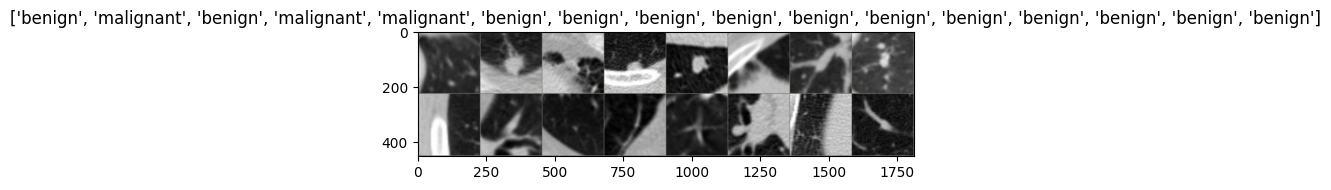

In [12]:
# Get a batch of testing data

inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def plot(val_loss,train_loss,typ):

    plt.title("{} after epoch: {}".format(typ,len(train_loss)))

    plt.xlabel("Epoch")

    plt.ylabel(typ)

    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)

    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)

    plt.legend()

    plt.savefig(os.path.join(data_dir,typ+".png"))

    plt.close()

In [14]:
val_loss_gph=[]

train_loss_gph=[]

val_acc_gph=[]

train_acc_gph=[]

## Model Training Function



This function encapsulates the model training logic. It takes a model, criterion for loss calculation, optimizer for backpropagation, and a scheduler for learning rate adjustment as inputs and conducts the training process.

# Experiments

In [15]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=39a6b76e504d8605236f8b9a15884a5d0e48586b5e462bcbd8182eeacbb5e3e3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import copy
import time
from torch.optim import lr_scheduler
import torch.optim as optim

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define number of classes
num_classes = 8631  # Adjust this based on your specific task

# 2. EfficientNet B3

In [17]:
import torch.nn.functional as F

class EfficientNetB7Model(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(EfficientNetB7Model, self).__init__()
        # Load pretrained EfficientNet-B7
        self.model = EfficientNet.from_pretrained('efficientnet-b7')
        
        # Extract the number of features from the original FC layer
        num_ftrs = self.model._fc.in_features
        
        # Modify the FC layer with dropout and a custom sequential block
        self.model._fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),      # Reduce feature dimensions
            nn.ReLU(inplace=True),        # Activation function
            nn.Dropout(dropout_rate),     # Dropout for regularization
            nn.Linear(512, num_classes)   # Final classification layer
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model
efficientnet_b7_model = EfficientNetB7Model(num_classes, dropout_rate=0.3).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 179MB/s] 


Loaded pretrained weights for efficientnet-b7


# Training Function

In [18]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model

# Training EfficientNet-B3:

In [19]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_efficientnet_b7 = optim.SGD(
    efficientnet_b7_model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4,
)
# scheduler_efficientnet_b7 = lr_scheduler.CosineAnnealingLR(optimizer_efficientnet_b7, T_max=10, eta_min=1e-6)
scheduler_efficientnet_b7 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_efficientnet_b7, T_max=10, eta_min=1e-6)

trained_efficientnet_b7_model = train_model(
    model=efficientnet_b7_model,
    criterion=criterion,
    optimizer=optimizer_efficientnet_b7,
    scheduler=scheduler_efficientnet_b7,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    num_epochs=10 # Adjust based on your config or needs.
)

Epoch 1/10
----------
train Loss: 2.2131 Acc: 0.7800
val Loss: 1.6061 Acc: 0.8604
Epoch 2/10
----------
train Loss: 1.4704 Acc: 0.9175
val Loss: 1.3830 Acc: 0.9476
Epoch 3/10
----------
train Loss: 1.4205 Acc: 0.9385
val Loss: 1.3563 Acc: 0.9537
Epoch 4/10
----------
train Loss: 1.3747 Acc: 0.9528
val Loss: 1.3454 Acc: 0.9614
Epoch 5/10
----------
train Loss: 1.3535 Acc: 0.9616
val Loss: 1.3268 Acc: 0.9661
Epoch 6/10
----------
train Loss: 1.3345 Acc: 0.9717
val Loss: 1.3350 Acc: 0.9653
Epoch 7/10
----------
train Loss: 1.3154 Acc: 0.9757
val Loss: 1.3106 Acc: 0.9684
Epoch 8/10
----------
train Loss: 1.3090 Acc: 0.9773
val Loss: 1.3189 Acc: 0.9692
Epoch 9/10
----------
train Loss: 1.3090 Acc: 0.9769
val Loss: 1.3142 Acc: 0.9707
Epoch 10/10
----------
train Loss: 1.2962 Acc: 0.9830
val Loss: 1.3168 Acc: 0.9692
Training complete in 43m 53s
Best Validation Accuracy: 0.9707


### Evaluate Train Accuracy on EfficientNet-B7 Model

In [20]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

train_accuracy_efficientnet_b7 = evaluate_accuracy(trained_efficientnet_b7_model, dataloaders['train'])
print("Train Accuracy (EfficientNet-B7) =", train_accuracy_efficientnet_b7)

Train Accuracy (EfficientNet-B7) = 99.01677270098322


### Evaluate Test Accuracy on EfficientNet-B7 Model

In [21]:
test_accuracy_efficientnet_b7 = evaluate_accuracy(trained_efficientnet_b7_model, dataloaders['test'])
print("Test Accuracy (EfficientNet-B7) =", test_accuracy_efficientnet_b7)

Test Accuracy (EfficientNet-B7) = 97.28729963008631


# AUC_ROC

AUC-ROC: 0.9921


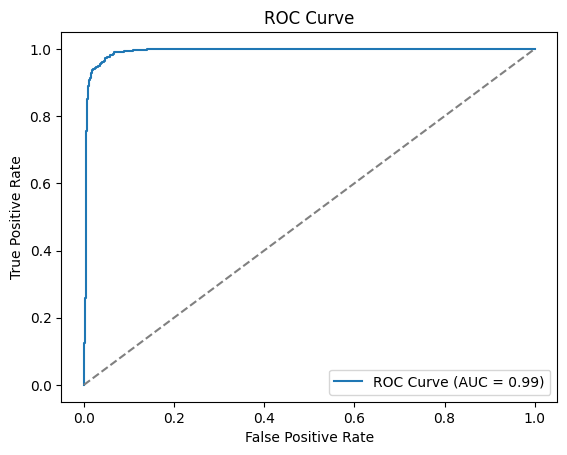

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def compute_auc_roc(model, dataloader, device, num_classes):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(probs[:, 1].cpu().numpy())  # Predicted probabilities for the positive class

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_true, y_pred)
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# usage:
compute_auc_roc(trained_efficientnet_b7_model, dataloaders['test'], device, num_classes)


# CONFUSION MATRIX

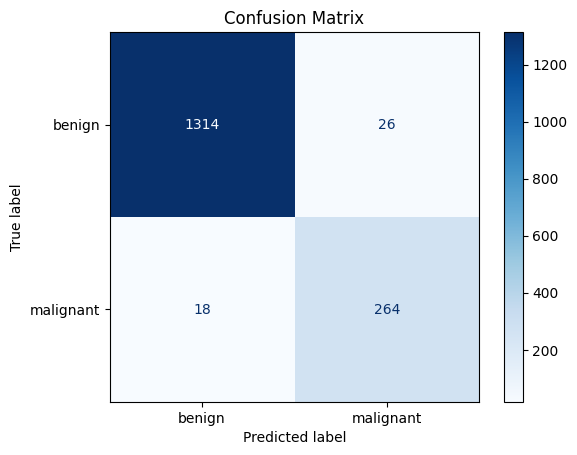

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_confusion_matrix(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Predicted classes

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# usage:
compute_confusion_matrix(trained_efficientnet_b7_model, dataloaders['test'], device)


# TEST ACCURACY

In [24]:
def compute_test_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# usage:
test_accuracy = compute_test_accuracy(trained_efficientnet_b7_model, dataloaders['test'], device)


Test Accuracy: 97.29%


# VALIDATION AND TEST ACCURACY IN THE TABLE

In [25]:
import pandas as pd

def log_accuracies(model, dataloaders, device):
    accuracies = {}
    for phase in ['val', 'test']:
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total * 100
        accuracies[phase] = accuracy

    # Create a DataFrame to display
    df = pd.DataFrame({'Phase': ['Validation', 'Test'], 'Accuracy (%)': [accuracies['val'], accuracies['test']]})
    print(df)
    return df

#  usage:
accuracy_table = log_accuracies(trained_efficientnet_b7_model, dataloaders, device)


        Phase  Accuracy (%)
0  Validation     97.070162
1        Test     97.287300


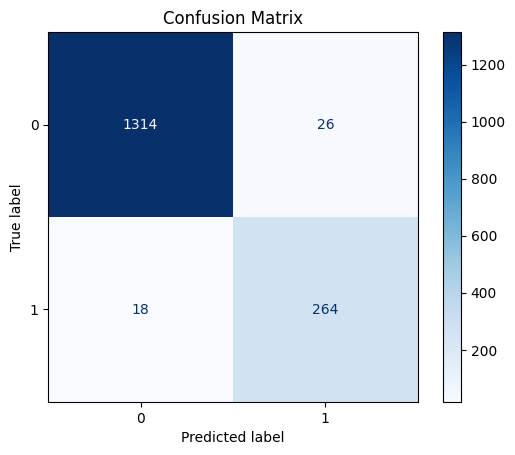

Accuracy: 0.9729
Precision: 0.9484
Recall: 0.9584
F1 Score: 0.9533


In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(model, dataloader, device, num_classes):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Predicted classes

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

#usage:
compute_metrics(trained_efficientnet_b7_model, dataloaders['test'], device, num_classes)